In [32]:
import control
from control.matlab import *
import numpy as np
import sympy as sp
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 1
%matplotlib inline

def mystepinfo(sys, t=None, SettlingTimeThreshold=0.02, RiseTimeLimits=[0.1,0.9]):
#     sys = control.timeresp._get_ss_simo(sys)
    
    t, step_out = control.step_response(sys, t)
    step_out = step_out.flatten()
        
    # Steady state value
    InfValue = step_out[-1]
    
    # RiseTime
    tr_lower_index = (np.where(step_out >= RiseTimeLimits[0] * InfValue)[0])[0]
    tr_upper_index = (np.where(step_out >= RiseTimeLimits[1] * InfValue)[0])[0]
    RiseTime = t[tr_upper_index] - t[tr_lower_index]

    # SettlingTime
    sup_margin = (1. + SettlingTimeThreshold) * InfValue
    inf_margin = (1. - SettlingTimeThreshold) * InfValue
    SettlingTime = 0
    for i in reversed(range(t.size)):
        if (step_out[i] <= inf_margin) | (step_out[i] >= sup_margin):
            if t.size > i + 1:
                i += 1
            SettlingTime = t[i]
            break
    
    # Peak
    PeakIndex = np.abs(step_out).argmax()
    PeakValue = step_out[PeakIndex]
    PeakTime = t[PeakIndex]
    SettlingMax = (step_out).max()
    SettlingMin = (step_out[tr_upper_index:]).min()
    UnderShoot = step_out.min()
    OverShoot = 100. * (step_out.max() -InfValue) / (InfValue -step_out[0])
    
    S = {
        'RiseTime': RiseTime,
        'SettlingTime': SettlingTime,
        'SettlingMin': SettlingMin,
        'SettlingMax': SettlingMax,
        'Overshoot': OverShoot,
        'Undershoot': UnderShoot,
        'Peak': PeakValue,
        'PeakTime': PeakTime,
        'SteadyStateValue': InfValue
    }

    return S

def FOM(S, SettlingTimeThreshold):
    # calcula o zeta necessário usando Mp
    zeta = -np.log(S['Overshoot'] / 100.) / np.sqrt( np.pi**2 + np.log(S['Overshoot'] / 100.)**2 )
    
    # calcula o wn necessário usando zeta
    try:
        wn = np.pi / (S['PeakTime'] * np.sqrt(1 - zeta**2) )
    except:
        wn = - np.log(SettlingTimeThreshold * np.sqrt(1 - zeta**2)) / (S['SettlingTime'] * zeta)
    Fn = wn * 2 * np.pi
    wd = wn * np.sqrt(1 - zeta**2)
    Fd = wd * 2 * np.pi
    
    FOM = {
        'zeta': zeta,
        'wn': wn,
        'Fn': Fn,
        'wd': wd,
        'Fd': Fd
    }
    return FOM

def zplane(sys, color='black'):
    t = np.arange(-np.pi, np.pi, 0.01)
    ax = np.arange(-1.1, 1.1, 0.01)
    plt.plot(np.cos(t), np.sin(t), lw=1)
    plt.plot(ax, ax * 0, color='black', lw=1)
    plt.plot(ax * 0, ax, color='black', lw=1)

    for p in pole(sys):
        plt.scatter(p.real, p.imag, marker='x', color=color, lw=10)
    for z in zero(sys):
        plt.scatter(z.real, z.imag, marker='o', facecolors='none', color=color, lw=10)


# 1. BLOCO DE SEGUNDA ORDEM

[!bloco_segunda_ordem]()

A função de transferência do bloco de segunda ordem é:

$$ G_2(s) = \frac{(2\pi\,w_n)^2}{s^2 +2\zeta(2\pi\,w_n)s +(2\pi\,w_n)^2} $$  

$$ w_n = \frac{1}{2\pi \sqrt{R_1 C_1 R_2 C_2}} $$

$$ R_1= \frac{(R_{1a} R_{1b})}{(R_{1a} + R_{1b})} $$
$$ R_{1a} = 33 \,k\Omega \pm 10\% $$
$$ R_{1b} = 39 \, k\Omega \pm 10\% $$
$$ R_{2} = 68 \, k\Omega \pm 10\% $$
$$ C_{1} = 700 \, nF \pm 20\% $$
$$ C_{2} = 100 \, nF \pm 20\% $$

R2a = 33000.0
R2b = 39000.0
R1 = 17875.0
R1 = 68000.0
C1 = 7e-07
C2 = 1e-07
wn = 17.254152413997854

        1.175e+04
-------------------------
s^2 + 100.9 s + 1.175e+04

T.size: 100
T.shape: (100,)
yout.size: 100
yout.shape: (100,)
{
    "RiseTime": 0.014011321365033157,
    "SettlingTime": 0.049039624777616045,
    "SettlingMin": 0.9277838533587892,
    "SettlingMax": 1.1913022492293326,
    "Overshoot": 19.24899706442737,
    "Undershoot": 0.0,
    "Peak": 1.1913022492293326,
    "PeakTime": 0.03222603913957626,
    "SteadyStateValue": 0.9990039988224811
}


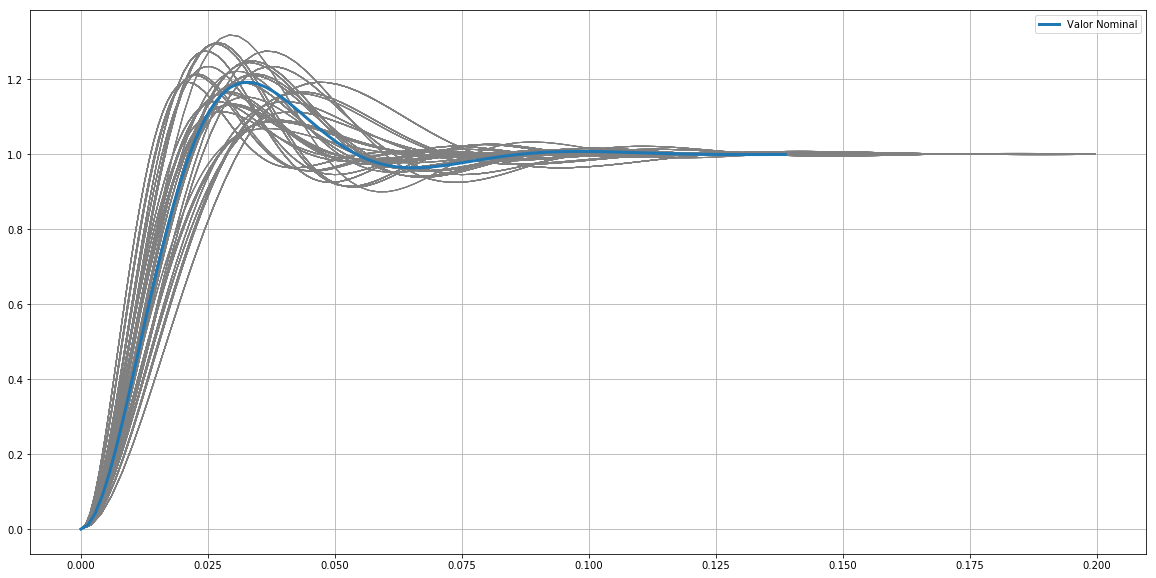

In [8]:
Rvar = 0.2
# Rvar_range = np.linspace(1 - Rvar, 1 + Rvar)
Rvar_range = np.array([1 - Rvar, 1 + Rvar])

Cvar = 0.2
# Cvar_range = np.linspace(1 - Cvar, 1 + Cvar)
Cvar_range = np.array([1 - Cvar, 1 + Cvar])

plt.figure(figsize=(20,10))

from random import shuffle
k = 0
for k in range(200):
    R2a = 33e3 * Rvar_range
    R2b = 39e3 * Rvar_range
    np.random.shuffle(R2a)
    np.random.shuffle(R2a)
    R2 = (R2a * R2b) / (R2a + R2b)
    R1 = 68e3 * Rvar_range
    C1 = 700e-9 * Cvar_range
    C2 = 100e-9 * Cvar_range
    
#     wn = 1 / (2 * np.pi * np.sqrt(R1 * C1 * R2 * C2))
    
    np.random.shuffle(R1)
    np.random.shuffle(C2)
    np.random.shuffle(C1)
    
    a = 1/(R1*C1*R2*C2)
    b = 1/(R1*C1)
    c = 1/(R2*C1)

    for a_,b_,c_ in zip(a,b,c):
        G2_s = tf([a_], [1, b_ + c_, a_])

        step_out, t = step(G2_s)
        plt.plot(t, step_out, color='gray')

R2a = 33e3
print(f'R2a = {R2a}')
R2b = 39e3
print(f'R2b = {R2b}')
R2 = (R2a * R2b) / (R2a + R2b)
print(f'R1 = {R2}')
R1 = 68e3
print(f'R1 = {R1}')
C1 = 700e-9
print(f'C1 = {C1}')
C2 = 100e-9
print(f'C2 = {C2}')
wn = 1 / (2 * np.pi * np.sqrt(R1 * C1 * R2 * C2))
print(f'wn = {wn}')
a = 2 * np.pi * wn
G2_s = tf([1 / (R1*C1*R2*C2)], [1, 1/(R1*C1) +1/(R2*C1), 1 / (R1*C1*R2*C2)])
print(G2_s)

step_out, t = step(G2_s)
plt.plot(t, step_out, label='Valor Nominal', lw=3)
plt.grid()
SettlingTimeThreshold = 0.05
S = stepinfo(G2_s, t, SettlingTimeThreshold=SettlingTimeThreshold)
plt.legend()
print(json.dumps(S, indent=4))

## 1.1 RESPOSTA AO DEGARU
![Resposta ao Degrau](SCT2_bloco2/ALL0000/F0000TEK.JPG)

## 1.2 TEMPO DE SUBIDA
![Tempo de Subida](SCT2_bloco2/ALL0001/F0001TEK.JPG)

In [9]:
v0 = 1.00
print(f'v0 = {v0} v')
vinf = 1.49
print(f'vinf = {vinf} v')

deltav = vinf - v0
print(f'deltav = {deltav} v')

v10 = deltav * 0.1 + v0
v90 = deltav * 0.9 + v0
print(f'v10 = {v10} v')
print(f'v90 = {v90} v')

t10 = 4.80e-3
t90 = 19.8e-3
print(f't10 = {t10} s')
print(f't90 = {t90} s')
RiseTime = t90 - t10
print(f'RiseTime = {RiseTime} s')

v0 = 1.0 v
vinf = 1.49 v
deltav = 0.49 v
v10 = 1.049 v
v90 = 1.441 v
t10 = 0.0048 s
t90 = 0.0198 s
RiseTime = 0.015000000000000003 s


## 1.3 TEMPO DE ATRASO
![Tempo de Atraso](SCT2_bloco2/ALL0002/F0002TEK.JPG)

In [10]:
deltav = vinf - v0
print(f'deltav = {deltav} v')

v50 = deltav * 0.5 + v0
print(f'v50 = {v50} v')
t50 = 12.0e-3
print(f'Delay = {t50} s')

deltav = 0.49 v
v50 = 1.245 v
Delay = 0.012 s


## 1.4 PICO E TEMPO DE PICO
![Pico e Tempo de Pico](SCT2_bloco2/ALL0003/F0003TEK.JPG)

In [11]:
PeakTime = 33.4e-3
print(f'PeakTime = {PeakTime} s')

PeakValue = 1.57
print(f'PeakValue = {PeakValue} v')

OverShoot = 100 * (PeakValue - vinf) / (vinf - v0)
print(f'OverShoot = {OverShoot} %')

PeakTime = 0.0334 s
PeakValue = 1.57 v
OverShoot = 16.326530612244913 %


## 1.5 TEMPO DE ACOMODAÇÃO
![Tempo de Acomodação](SCT2_bloco2/ALL0004/F0004TEK.JPG)

In [12]:
SettlingTimeThreshold = 0.05
sup_margin = (1. + SettlingTimeThreshold) * deltav +v0
inf_margin = (1. - SettlingTimeThreshold) * deltav +v0
print(f'sup_margin = {sup_margin} v')
print(f'inf_margin = {inf_margin} v')
SettlingTime = 47.6e-3
print(f'SettlingTime = {SettlingTime} s')

sup_margin = 1.5145 v
inf_margin = 1.4655 v
SettlingTime = 0.0476 s


## 1.6 FUNÇÃO DE TRANSFERÊNCIA EQUIVALENTE

In [13]:
zeta = -np.log(OverShoot / 100.) / np.sqrt(  (-np.pi)**2 + (np.log(OverShoot / 100.))**2  )
wn = np.pi / (PeakTime * np.sqrt(1 - zeta**2) )
print(f'zeta = {zeta}')
print(f'wn = {wn}')
zeta_check = np.sqrt(1 - ((np.pi)/(wn * PeakTime))**2)
print(f'zeta_check = {zeta_check}')

zeta = 0.4997062054306522
wn = 108.58948003681807
zeta_check = 0.499706205430652



        3.768e+05
-------------------------
s^2 + 613.5 s + 3.768e+05

T.size: 100
T.shape: (100,)
yout.size: 100
yout.shape: (100,)
{
    "RiseTime": 0.002765961766850457,
    "SettlingTime": 0.00875887892835978,
    "SettlingMin": 0.9506004297439169,
    "SettlingMax": 1.1630480577561257,
    "Overshoot": 16.375493607706183,
    "Undershoot": 0.0,
    "Peak": 1.1630480577561257,
    "PeakTime": 0.005992917161509324,
    "SteadyStateValue": 0.9993925883370953
}
{
    "zeta": 0.4990863513413393,
    "wn": 604.9463217043816,
    "Fn": 3800.989840165306,
    "wd": 524.2176003645242,
    "Fd": 3293.7563243753184
}


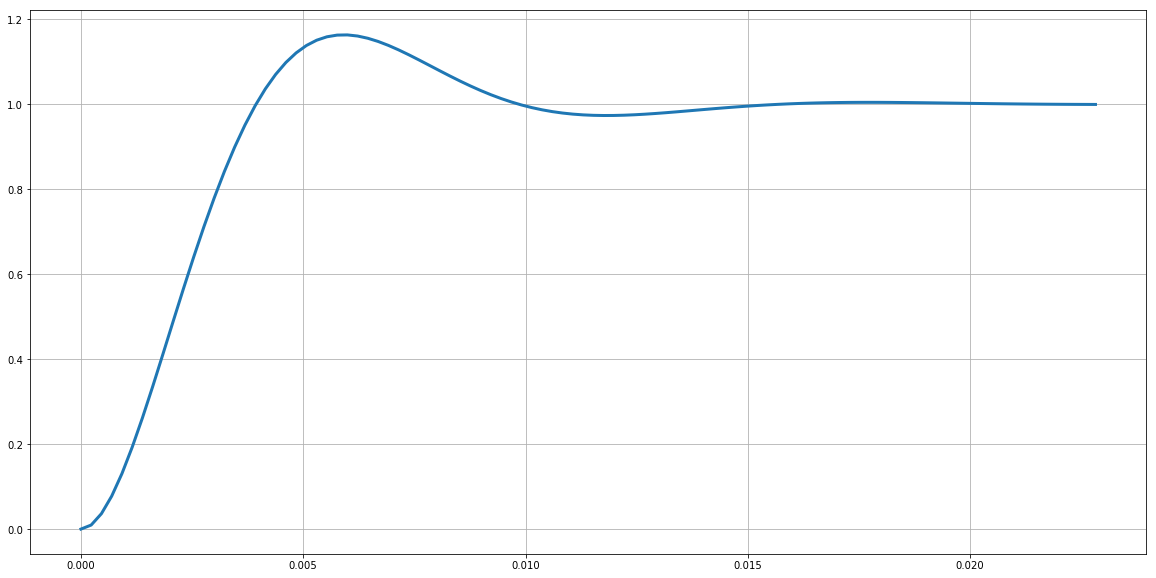

In [21]:
G2_s = tf([wn**2],[1, 2 * zeta * wn, wn**2])
print(G2_s)

plt.figure(figsize=(20,10))
step_out, t = step(G2_s)
plt.plot(t, step_out, lw=3)
plt.grid()

S = stepinfo(G2_s, t, SettlingTimeThreshold=SettlingTimeThreshold)

print(json.dumps(S, indent=4))
print(json.dumps(FOM(S, SettlingTimeThreshold), indent=4))

R2a = 33000.0
R2b = 39000.0
R1 = 17875.0
R1 = 68000.0
C1 = 7e-07
C2 = 1e-07
wn = 17.254152413997854

        1.175e+04
-------------------------
s^2 + 100.9 s + 1.175e+04

zeta = 0.4997062054306522
wn = 108.58948003681807
zeta_check = 0.499706205430652

        1.179e+04
-------------------------
s^2 + 108.5 s + 1.179e+04



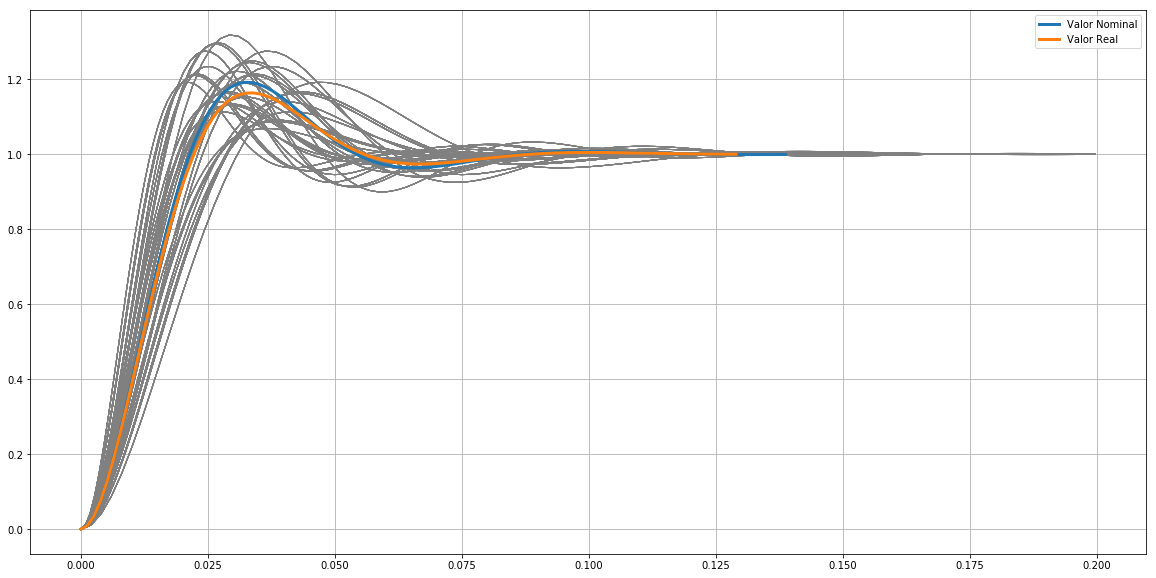

In [25]:
Rvar = 0.2
Rvar_range = np.array([1 - Rvar, 1 + Rvar])

Cvar = 0.2
Cvar_range = np.array([1 - Cvar, 1 + Cvar])
plt.figure(figsize=(20,10))
from random import shuffle
k = 0
for k in range(200):
    R2a = 33e3 * Rvar_range
    R2b = 39e3 * Rvar_range
    np.random.shuffle(R2a)
    np.random.shuffle(R2a)
    R2 = (R2a * R2b) / (R2a + R2b)
    R1 = 68e3 * Rvar_range
    C1 = 700e-9 * Cvar_range
    C2 = 100e-9 * Cvar_range
    
    np.random.shuffle(R1)
    np.random.shuffle(C2)
    np.random.shuffle(C1)
    
    a = 1/(R1*C1*R2*C2)
    b = 1/(R1*C1)
    c = 1/(R2*C1)

    for a_,b_,c_ in zip(a,b,c):
        G2_s = tf([a_], [1, b_ + c_, a_])

        step_out, t = step(G2_s)
        plt.plot(t, step_out, color='gray')

R2a = 33e3
print(f'R2a = {R2a}')
R2b = 39e3
print(f'R2b = {R2b}')
R2 = (R2a * R2b) / (R2a + R2b)
print(f'R1 = {R2}')
R1 = 68e3
print(f'R1 = {R1}')
C1 = 700e-9
print(f'C1 = {C1}')
C2 = 100e-9
print(f'C2 = {C2}')
wn = 1 / (2 * np.pi * np.sqrt(R1 * C1 * R2 * C2))
print(f'wn = {wn}')
a = 2 * np.pi * wn

G2_s = tf([1 / (R1*C1*R2*C2)], [1, 1/(R1*C1) +1/(R2*C1), 1 / (R1*C1*R2*C2)])
print(G2_s)

step_out, t = step(G2_s)
plt.plot(t, step_out, label='Valor Nominal', lw=3)
plt.grid()

#############################################

zeta = -np.log(OverShoot / 100.) / np.sqrt(  (-np.pi)**2 + (np.log(OverShoot / 100.))**2  )
wn = np.pi / (PeakTime * np.sqrt(1 - zeta**2) )
print(f'zeta = {zeta}')
print(f'wn = {wn}')
zeta_check = np.sqrt(1 - ((np.pi)/(wn * PeakTime))**2)
print(f'zeta_check = {zeta_check}')

G2_s = tf([wn**2],[1, 2 * zeta * wn, wn**2])
print(G2_s)

step_out, t = step(G2_s)
plt.plot(t, step_out, label="Valor Real", lw=3)

plt.legend()

# 2. BLOCO DE PRIMEIA ORDEM

## 2.1 RESPOSTA AO DEGARU
![Resposta ao Degrau](SCT2_bloco1/ALL0000/F0000TEK.JPG)

## 2.2 TEMPO DE SUBIDA
![Tempo de Subida](SCT2_bloco1/ALL0001/F0001TEK.JPG)

In [16]:
v0 = 0.996
print(f'v0 = {v0} v')
vinf = 1.49
print(f'vinf = {vinf} v')

deltav = vinf - v0
print(f'deltav = {deltav} v')

v10 = deltav * 0.1 + v0
v90 = deltav * 0.9 + v0
print(f'v10 = {v10} v')
print(f'v90 = {v90} v')

t10 = 600e-6
t90 = 3.72e-3
print(f't10 = {t10} s')
print(f't90 = {t90} s')
RiseTime = t90 - t10
print(f'RiseTime = {RiseTime} s')

v0 = 0.996 v
vinf = 1.49 v
deltav = 0.494 v
v10 = 1.0453999999999999 v
v90 = 1.4405999999999999 v
t10 = 0.0006 s
t90 = 0.00372 s
RiseTime = 0.0031200000000000004 s


## 2.3 TEMPO DE ESTABILIZAÇÃO
![Resposta de Estabilização](SCT2_bloco1/ALL0002/F0002TEK.JPG)

In [17]:
deltav = vinf - v0
print(f'deltav = {deltav} v')

v95 = deltav * 0.95 + v0
print(f'v95 = {v95} v')
t95 = 4.88e-3
print(f'Delay = {t95} s')

deltav = 0.494 v
v95 = 1.4653 v
Delay = 0.00488 s


## 2.4 FUNÇÃO DE TRANSFERÊNCIA EQUIVALENTE

In [30]:
tau = - t95 / np.log(0.05)
wn = 1/tau
print(f'tau = {tau}')
print(f'wn = {wn}')

tau = 0.0016289840193932303
wn = 613.879564252867



  613.9
---------
s + 613.9


  666.7
---------
s + 666.7

T.size: 100
T.shape: (100,)
yout.size: 100
yout.shape: (100,)
T.size: 100
T.shape: (100,)
yout.size: 100
yout.shape: (100,)
{
    "RiseTime": 0.0036060606060606057,
    "SettlingTime": 0.004878787878787878,
    "SettlingMin": 0.9040476716735438,
    "SettlingMax": 0.9984127231827762,
    "Overshoot": 0.0,
    "Undershoot": 0.0,
    "Peak": 0.9984127231827762,
    "PeakTime": 0.010499999999999999,
    "SteadyStateValue": 0.9984127231827762
}
{
    "RiseTime": 0.0032878787878787875,
    "SettlingTime": 0.00456060606060606,
    "SettlingMin": 0.9030280321355943,
    "SettlingMax": 0.9990881180344444,
    "Overshoot": 0.0,
    "Undershoot": 0.0,
    "Peak": 0.9990881180344444,
    "PeakTime": 0.010499999999999999,
    "SteadyStateValue": 0.9990881180344444
}


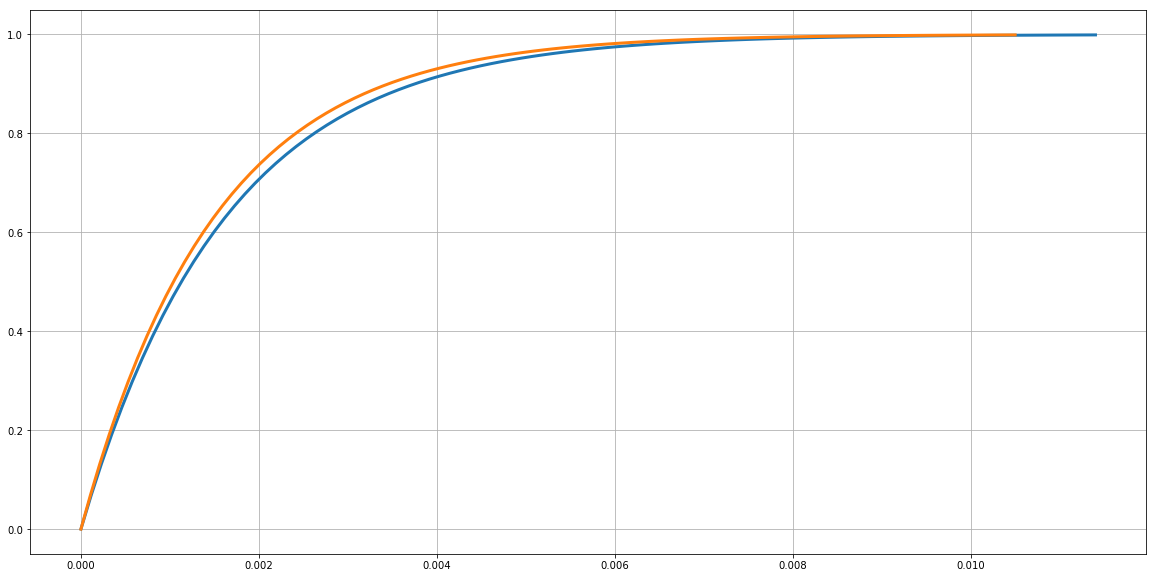

In [34]:
plt.figure(figsize=(20,10))
G1_s = tf([1 / tau],[1, 1 / tau])
tau_nominal = (10e3 * 150e-9)
G1_s_nominal = tf([1 / tau_nominal],[1, 1 / tau_nominal])
print(G1_s)
print(G1_s_nominal)

step_out, t = step(G1_s)
plt.plot(t, step_out, lw=3)
step_out, t = step(G1_s_nominal)
plt.plot(t, step_out, lw=3)
plt.grid()

S = stepinfo(G1_s, t, SettlingTimeThreshold=SettlingTimeThreshold)
S_nominal = stepinfo(G1_s_nominal, t, SettlingTimeThreshold=SettlingTimeThreshold)
print(json.dumps(S, indent=4))
print(json.dumps(S_nominal, indent=4))

# 3 FUNÇÃO DE TRANSFERÊNCIA DA PLANTA COMPELTA


                7.239e+06
-----------------------------------------
s^3 + 722.4 s^2 + 7.841e+04 s + 7.239e+06

T.size: 100
T.shape: (100,)
yout.size: 100
yout.shape: (100,)
{
    "RiseTime": 0.015636573668080363,
    "SettlingTime": 0.050818864421261184,
    "SettlingMin": 0.9339053112958997,
    "SettlingMax": 1.160441046696975,
    "Overshoot": 16.101438379329213,
    "Undershoot": 0.0,
    "Peak": 1.160441046696975,
    "PeakTime": 0.03518229075318082,
    "SteadyStateValue": 0.9995061757164077
}


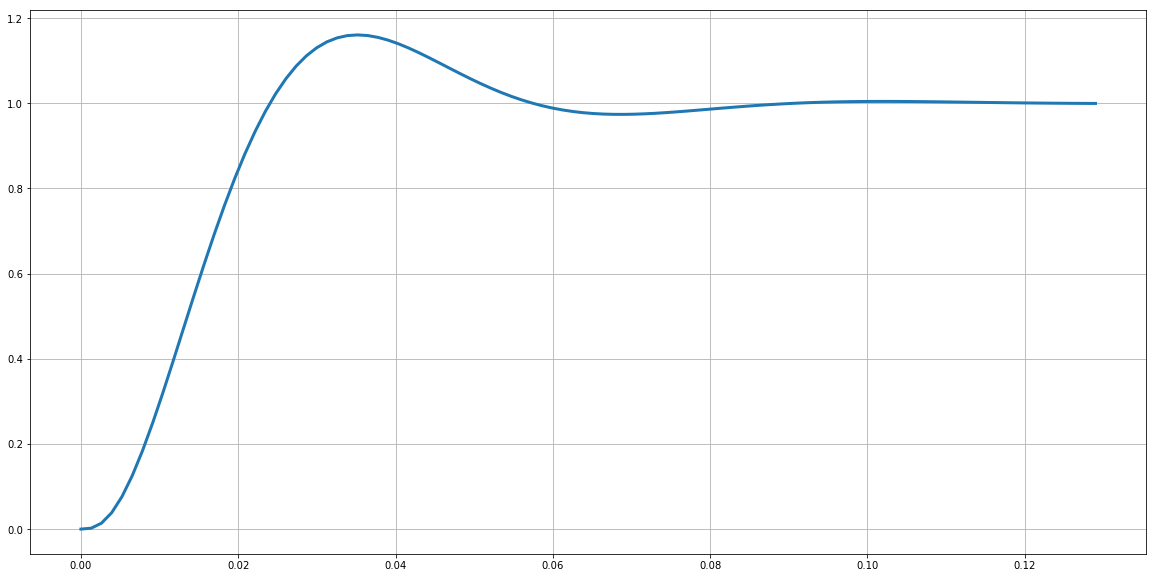

In [24]:
G_s = G1_s * G2_s
print(G_s)

plt.figure(figsize=(20,10))
step_out, t = step(G_s)
plt.plot(t, step_out, lw=3)
plt.grid()

S = stepinfo(G_s, t, SettlingTimeThreshold=SettlingTimeThreshold)

print(json.dumps(S, indent=4))